<a href="https://colab.research.google.com/github/oshita30/ML-basics/blob/main/MagNet/MagNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://www.ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip
!unzip public.zip

--2022-01-06 08:10:43--  https://www.ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip
Resolving www.ngdc.noaa.gov (www.ngdc.noaa.gov)... 140.172.190.1
Connecting to www.ngdc.noaa.gov (www.ngdc.noaa.gov)|140.172.190.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 287399979 (274M) [application/zip]
Saving to: ‘public.zip’

public.zip          100%[===================>] 274.09M  1.33MB/s    in 3m 15s  

2022-01-06 08:13:59 (1.41 MB/s) - ‘public.zip’ saved [287399979/287399979]

Archive:  public.zip
   creating: public/
  inflating: public/sunspots.csv     
  inflating: public/satellite_positions.csv  
  inflating: public/dst_labels.csv   
  inflating: public/solar_wind.csv   


In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from tensorflow.keras import preprocessing

#%load_ext nb_black
%matplotlib inline

In [ ]:
dst = pd.read_csv("/content/public/dst_labels.csv")
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

sunspots = pd.read_csv("/content/public/sunspots.csv")
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

solar_wind = pd.read_csv("/content/public/solar_wind.csv")
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

In [ ]:

from sklearn.preprocessing import StandardScaler

# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    "phi_gsm",
    "bx_gsm",
    "by_gsm",
    "bz_gsm",
    "speed",
    "density",
]

# all of the features we'll use, including sunspot numbers
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)


def impute_features(feature_df):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]

    # aggregate solar wind data and join with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler

In [ ]:
features, scaler = preprocess_features(solar_wind, sunspots, subset=SOLAR_WIND_FEATURES)
print(features.shape)
features.head()

(139872, 17)


bt_mean    bt_std  ...  density_std  smoothed_ssn
period  timedelta                            ...                           
train_a 0 days 00:00:00  0.499705  2.443614  ...    -0.205724      0.139444
        0 days 01:00:00  0.547177 -0.224580  ...    -0.058215      0.139444
        0 days 02:00:00  0.739905 -0.770240  ...    -0.220012      0.139444
        0 days 03:00:00  0.699098 -0.278783  ...     0.218373      0.139444
        0 days 04:00:00  0.223933 -0.225168  ...     0.097253      0.139444

[5 rows x 17 columns]

In [ ]:
# check to make sure missing values are filled
(features.isna().sum() == 0).all()

True

In [ ]:
all(features.index == dst.index)

True

### Before we start modeling, we also have to reshape our label, dst. Remember that we have to predict both t0, the current timestep, and t+1, an hour ahead. We'll train our LSTM to do multi-step prediction by providing it both steps. To do that, we just add another column called t1 that is dst shifted by 1. We'll also renamed our dst column to t0 for consistency

In [ ]:
YCOLS = ["t0", "t1"]


def process_labels(dst):
    y = dst.copy()
    y["t0"] = y.groupby("period").dst.shift(-1)
    y["t1"] = y.groupby("period").dst.shift(-2)
    return y[YCOLS]


labels = process_labels(dst)
labels.head()

t0    t1
period  timedelta                  
train_a 0 days 00:00:00 -10.0 -10.0
        0 days 01:00:00 -10.0  -6.0
        0 days 02:00:00  -6.0  -2.0
        0 days 03:00:00  -2.0   3.0
        0 days 04:00:00   3.0   5.0

### Now we have our features and our labels. Let's join them together into one data df so that it's easier to keep the appropriate rows together when splitting into our train, test, and validation sets.

In [ ]:
data = labels.join(features)
data.head()

t0    t1  ...  density_std  smoothed_ssn
period  timedelta                    ...                           
train_a 0 days 00:00:00 -10.0 -10.0  ...    -0.205724      0.139444
        0 days 01:00:00 -10.0  -6.0  ...    -0.058215      0.139444
        0 days 02:00:00  -6.0  -2.0  ...    -0.220012      0.139444
        0 days 03:00:00  -2.0   3.0  ...     0.218373      0.139444
        0 days 04:00:00   3.0   5.0  ...     0.097253      0.139444

[5 rows x 19 columns]

### We also know that the three periods are differently distributed. That suggests that observations from each period should be included in our train set, instead of reserving one wholesale as our test or validation set.



In [ ]:
def get_train_test_val(data, test_per_period, val_per_period):
    """Splits data across periods into train, test, and validation"""
    # assign the last `test_per_period` rows from each period to test
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    # assign the last `val_per_period` from the remaining rows to validation
    val = interim.groupby("period").tail(val_per_period)
    # the remaining rows are assigned to train
    train = interim[~interim.index.isin(val.index)]
    return train, test, val


train, test, val = get_train_test_val(data, test_per_period=6_000, val_per_period=3_000)

In [ ]:
data_config = {
    "timesteps": 32,
    "batch_size": 32,
}


def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset


train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of val batches: {len(val_ds)}")

Number of train batches: 3523
Number of val batches: 276


In [ ]:
data_config["batch_size"]

32

In [ ]:
temp = pd.DataFrame(train_ds)

In [ ]:
from keras.layers import Dense, LSTM
from keras.models import Sequential

# define our model
model_config = {"n_epochs": 20, "n_neurons": 512, "dropout": 0.4, "stateful": False}

model = Sequential()
model.add(
    LSTM(
        model_config["n_neurons"],
        # usually set to (`batch_size`, `sequence_length`, `n_features`)
        # setting the batch size to None allows for variable length batches
        batch_input_shape=(None, data_config["timesteps"], len(XCOLS)),
        stateful=model_config["stateful"],
        dropout=model_config["dropout"],
    )
)
model.add(Dense(len(YCOLS)))
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1085440   
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 1,086,466
Trainable params: 1,086,466
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    train_ds,
    batch_size=data_config["batch_size"],
    epochs=model_config["n_epochs"],
    verbose=0,
    shuffle=False,
    validation_data=val_ds,
)

loss
[95.26970672607422, 93.50337982177734, 91.94682312011719, 89.26710510253906, 87.23397827148438, 86.46614837646484, 84.20191192626953, 81.59308624267578, 80.62832641601562, 77.8014907836914, 76.4067153930664, 74.71691131591797, 74.23197937011719, 72.70649719238281, 71.7718734741211, 69.36102294921875, 68.55958557128906, 67.77828216552734, 66.24164581298828, 65.12492370605469]

val_loss
[179.05859375, 184.8273468017578, 187.7783203125, 188.62844848632812, 194.1012420654297, 192.2233123779297, 197.31141662597656, 197.5206756591797, 207.0099639892578, 202.87911987304688, 208.72610473632812, 216.50262451171875, 203.50741577148438, 227.61695861816406, 222.6201629638672, 228.55299377441406, 227.17222595214844, 230.97669982910156, 228.3570098876953, 223.2735595703125]



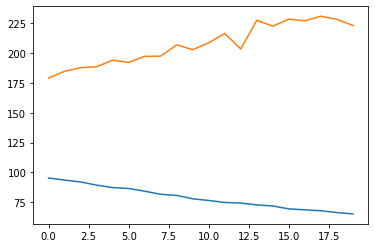

In [ ]:
for name, values in history.history.items():
  print(name)
  print(values)
  print()
  plt.plot(values)
  # Saving the figure.
  plt.savefig("model1.png")

In [ ]:
history.history

{'loss': [95.26970672607422,
  93.50337982177734,
  91.94682312011719,
  89.26710510253906,
  87.23397827148438,
  86.46614837646484,
  84.20191192626953,
  81.59308624267578,
  80.62832641601562,
  77.8014907836914,
  76.4067153930664,
  74.71691131591797,
  74.23197937011719,
  72.70649719238281,
  71.7718734741211,
  69.36102294921875,
  68.55958557128906,
  67.77828216552734,
  66.24164581298828,
  65.12492370605469],
 'val_loss': [179.05859375,
  184.8273468017578,
  187.7783203125,
  188.62844848632812,
  194.1012420654297,
  192.2233123779297,
  197.31141662597656,
  197.5206756591797,
  207.0099639892578,
  202.87911987304688,
  208.72610473632812,
  216.50262451171875,
  203.50741577148438,
  227.61695861816406,
  222.6201629638672,
  228.55299377441406,
  227.17222595214844,
  230.97669982910156,
  228.3570098876953,
  223.2735595703125]}

In [ ]:
len(values)

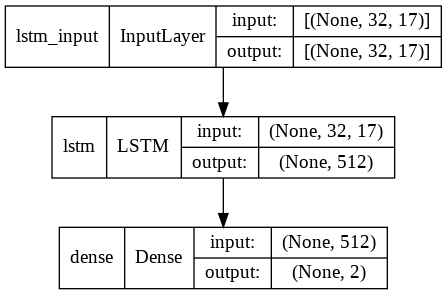

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
pwd

'/content'

In [ ]:
values

[179.05859375,
 184.8273468017578,
 187.7783203125,
 188.62844848632812,
 194.1012420654297,
 192.2233123779297,
 197.31141662597656,
 197.5206756591797,
 207.0099639892578,
 202.87911987304688,
 208.72610473632812,
 216.50262451171875,
 203.50741577148438,
 227.61695861816406,
 222.6201629638672,
 228.55299377441406,
 227.17222595214844,
 230.97669982910156,
 228.3570098876953,
 223.2735595703125]

In [ ]:
history.history

{'loss': [95.26970672607422,
  93.50337982177734,
  91.94682312011719,
  89.26710510253906,
  87.23397827148438,
  86.46614837646484,
  84.20191192626953,
  81.59308624267578,
  80.62832641601562,
  77.8014907836914,
  76.4067153930664,
  74.71691131591797,
  74.23197937011719,
  72.70649719238281,
  71.7718734741211,
  69.36102294921875,
  68.55958557128906,
  67.77828216552734,
  66.24164581298828,
  65.12492370605469],
 'val_loss': [179.05859375,
  184.8273468017578,
  187.7783203125,
  188.62844848632812,
  194.1012420654297,
  192.2233123779297,
  197.31141662597656,
  197.5206756591797,
  207.0099639892578,
  202.87911987304688,
  208.72610473632812,
  216.50262451171875,
  203.50741577148438,
  227.61695861816406,
  222.6201629638672,
  228.55299377441406,
  227.17222595214844,
  230.97669982910156,
  228.3570098876953,
  223.2735595703125]}

In [ ]:
from keras.layers import Dense, LSTM,GRU, Bidirectional, Dropout, GlobalAveragePooling1D,Input,Concatenate,Flatten,Embedding,Reshape,Conv1D,TimeDistributed,BatchNormalization,GaussianNoise
from keras.models import Sequential, Model

# define our model
model_config = {"n_epochs": 30, "n_neurons": 192*2 , "dropout": 0.0, "stateful": False}

input1 = Input(shape=( data_config["timesteps"], len(XCOLS)), name='x1')
lstm1= Bidirectional(LSTM(
        model_config["n_neurons"],
        stateful=model_config["stateful"],
        dropout=model_config["dropout"],return_sequences=True
    ))(input1)
gru1= Bidirectional(GRU(
         model_config["n_neurons"] *3,   
        stateful=model_config["stateful"],
        dropout=0.0,return_sequences=True
    ))(lstm1)

gaverage = Flatten() (gru1)
dense1 = Dense(96)(gaverage)
dense1 = Dense(128)(dense1)
dense1 = Dense(64)(dense1)
dense = Dense(2)(dense1)


model = Model(inputs=input1, outputs=dense)
model.compile(
    loss='mean_squared_error',
    optimizer='adam',
)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x1 (InputLayer)             [(None, 32, 17)]          0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 32, 768)          1234944   
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 32, 2304)         13284864  
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 73728)             0         
                                                                 
 dense_13 (Dense)            (None, 96)                7077984   
                                                                 
 dense_14 (Dense)            (None, 128)               1241

In [ ]:
history1 = model.fit(
    train_ds,
    batch_size=data_config["batch_size"],
    epochs=model_config["n_epochs"],
    verbose=0,
    shuffle=False,
    validation_data=val_ds,
)